# Example 02

This example reproduces the results from Example 2 of from Quast & Wagner (2016)

The definition of the volume phase function and surface BRDF is as follows:

**Volume definition**

* optical depth ($\tau = 0.7$)
* single scattering albedo ($\omega = 0.3$)
* Volume phase function: HanyeyGreenstein function with 20 coefficients

**Surface definition**

* Cosine Lobe function with 10 coefficients

In [2]:
# imports
from rt1.rt1 import RT1 
from rt1.volume import HenyeyGreenstein   
from rt1.surface import CosineLobe 

In [3]:
# definition of volume and surface
V = HenyeyGreenstein(tau=0.7, omega=0.3, t=0.7, ncoefs=20)
SRF = CosineLobe(ncoefs=10, i=5)

**Imaging geometry (backscattering case)**

In [4]:
import numpy as np
# Specify imaging geometry
inc = np.arange(1.,89.,1.)  # specify incidence angle range [deg]
t_0 = np.deg2rad(inc)  # [rad]
# scattering angle; here the same as incidence angle, as backscatter
t_ex = t_0*1. 
# azimuth geometry angles
p_0 = np.ones_like(inc)*0. 
p_ex = np.ones_like(inc)*0. + np.pi  # 180 degree shift as backscatter

**Perform the simulations**

To perform the simulations, the RT model needs to estimate once coefficients. As these are the same for all imaging geometries, it makes sense to estimate these once and then transfer them to the subsequent calls.

In [5]:
# initial call to estimate coefficients (can be also omitted, but performance gets better like so)
I0=1.  # set incident intensity
R = RT1(I0, 0., 0., 0., 0., RV=V, SRF=SRF, geometry='mono')  
fn = R.fn  # store coefficients for faster iteration 


In [6]:
# do actual calculations with specifies geometries
R = RT1(I0, t_0, t_ex, p_0, p_ex, RV=V, SRF=SRF, fn=fn, geometry='mono')
Itot, Isurf, Ivol, Iint = R.calc()

**Plot results**

Plot both, the phase function and the BRDF. For more examples, see [examples.py](examples.py)

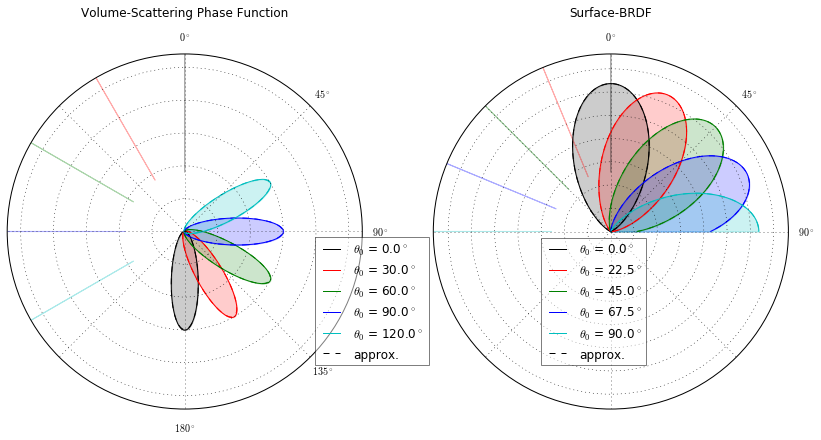

In [7]:
from rt1.rtplots import Plots

# plot BRDF and phase function
plot1 = Plots().polarplot(R,incp = list(np.linspace(0,120,5)), incBRDF =  list(np.linspace(0,90,5)) , pmultip = 1.5, plegpos = (0.85,0.5))

# plot only BRDF
#Plots().polarplot(SRF = R.SRF)

#plot only p
#Plots().polarplot(V = R.RV)

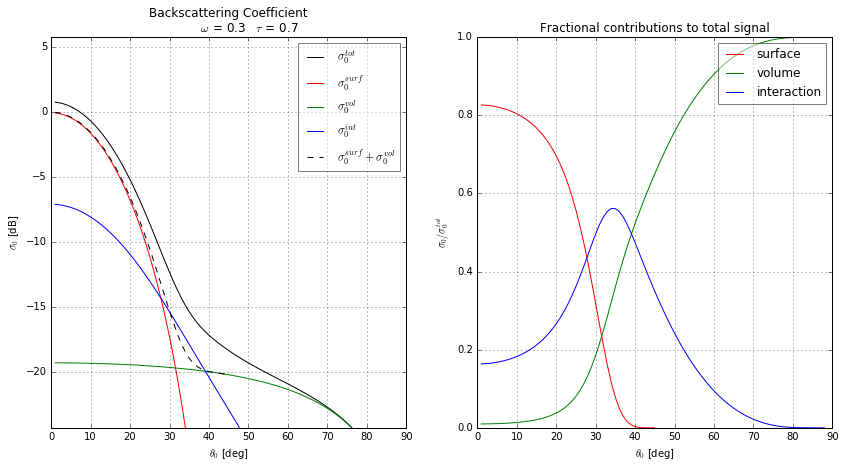

In [8]:
# plot backscatter as function of incidence angle
plot2 = Plots().logmono(inc, Itot = Itot, Isurf = Isurf, Ivol = Ivol, Iint      = Iint, sig0=True, noint=True, label='Backscattering Coefficient'+'\n           $\\omega$ = ' + str(R.RV.omega) + '$ \quad \\tau$ = ' + str(R.RV.tau))